# A STUDY ON COVID-19 CASES BY MUNICIPALITY IN THE NETHERLANDS  ON THE REALTIME RIVM.NL DATABASE (6/IV)

In [44]:
#Importing the relevant libraries

from bs4 import BeautifulSoup
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
import requests
from lxml import html
%matplotlib inline


## PART - I  TOTAL CASE & DEATH NUMBER VIA RIVM.NL / DATASET 1

In [45]:
# Scrapping the data via BS4
request_data1=requests.get('https://www.rivm.nl/coronavirus-kaart-van-nederland').text
soup1 = BeautifulSoup(request_data1,'html.parser')
#print(soup.prettify())

In [46]:
#Scrapping the table from the raw data
my_table1=soup1.find_all('table')

In [47]:
#Setting a dataframe
df1= pd.read_html(str(my_table1), index_col=False, header=None)[0]
df1.head(15)

,0,1
0,Positief geteste personen,18.803* (+952)
1,Ziekenhuisopnames,7.135 (+260)
2,Overleden personen,1.867** (+101)


In [48]:
#Data Wrangling 
df1=df1.T
headers=["People tested positive", "Admitted to Hospital", "Death"]
df1.columns=headers
df1.drop(df1.index[0], inplace=True)
df1.head()

#First row shows the current total numbers, the number between parantheses shows the daily increase per column. 


,People tested positive,Admitted to Hospital,Death
1,18.803* (+952),7.135 (+260),1.867** (+101)


## PART-II NUMBERS OF CASES BY MUNICIPALITY VIA RIVM.NL / DATASET 2

#### SCRAPING AND SAVING THE DATA AS CSV

In [49]:
#Scraping dataset via request
RIVM_URL = "https://www.rivm.nl/coronavirus-kaart-van-nederland"
url = requests.get(RIVM_URL)
web = html.fromstring(url.content)
data = web.get_element_by_id("csvData").text

with open("dataset.csv", "w", encoding="utf-8") as f:
    f.write(data)

#### DATA WRANGLING

In [50]:
df2=pd.read_csv("dataset.csv", sep=";", header=None, index_col=None)
df2=df2.drop(0)
#df2=df2.drop(1)
headers=["Gemnr","Municipality","Case_Number","Population","1/100.000",]
df2.columns=headers
df2=df2.drop(df2.columns[0], axis=1)
df2=df2.drop(df2.columns[3], axis=1)
#df2=df2.drop(df2.columns[2], axis=1)

df2.head()

,Municipality,Case_Number,Population
1,'s-Hertogenbosch,87,155113
2,Aa en Hunze,1,25453
3,Aalsmeer,8,31857
4,Aalten,1,27117
5,Achtkarspelen,0,27836


In [51]:
df2['Population'] = pd.to_numeric(df2['Population'])

In [52]:
df2['Case_Number'] = pd.to_numeric(df2['Case_Number'])

In [53]:
df2.dtypes

Municipality    object
Case_Number      int64
Population       int64
dtype: object

In [54]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 355 entries, 1 to 355
Data columns (total 3 columns):
Municipality    355 non-null object
Case_Number     355 non-null int64
Population      355 non-null int64
dtypes: int64(2), object(1)
memory usage: 11.1+ KB


In [55]:
df2.isnull().sum()

Municipality    0
Case_Number     0
Population      0
dtype: int64

## PART-III SCRAPING PROVINCES FROM WIKIPEDIA / DATASET 3  

In [56]:
# Scrapping the data via BS4
request_data2=requests.get('https://simple.wikipedia.org/wiki/List_of_municipalities_of_the_Netherlands').text
soup2 = BeautifulSoup(request_data2,'html.parser')
#print(soup.prettify())

In [57]:
#Scrapping the table from the raw data
my_table2=soup2.find_all('table')

In [58]:
df3= pd.read_html(str(my_table2))[1]
df3.head(15)

,Municipality,Province
0,Aa en Hunze,Drenthe
1,Aalburg,North Brabant
2,Aalsmeer,North Holland
3,Aalten,Gelderland
4,Achtkarspelen,Friesland
5,Alblasserdam,South Holland
6,Albrandswaard,South Holland
7,Alkmaar,North Holland
8,Almelo,Overijssel
9,Almere,Flevoland


In [59]:
df3.shape

(380, 2)

## PART-IV MERGING The DATASET 2 WITH The DATASET 3

In [60]:
df=pd.merge(df2,df3[['Municipality','Province']], on='Municipality', how="left") #Left join

In [61]:
df.head()

,Municipality,Case_Number,Population,Province
0,'s-Hertogenbosch,87,155113,North Brabant
1,Aa en Hunze,1,25453,Drenthe
2,Aalsmeer,8,31857,North Holland
3,Aalten,1,27117,Gelderland
4,Achtkarspelen,0,27836,Friesland


In [62]:
df.tail(5)

,Municipality,Case_Number,Population,Province
350,Zundert,14,21821,North Brabant
351,Zutphen,11,47942,Gelderland
352,Zwartewaterland,22,22690,Overijssel
353,Zwijndrecht,11,44741,South Holland
354,Zwolle,38,128831,Overijssel


In [63]:
df2.Municipality.isin(df3.Municipality).value_counts() # Comparing the dataset1 and dataset2 by municipality numbers

True     343
False     12
Name: Municipality, dtype: int64

In [64]:
df.Municipality.count() # Municipality Number in the NL

355

In [65]:
df.Province.value_counts()

North Brabant    61
Gelderland       50
South Holland    49
North Holland    46
Limburg          29
Utrecht          25
Overijssel       25
Friesland        17
Zeeland          13
Drenthe          12
Groningen        10
Flevoland         6
Name: Province, dtype: int64

In [66]:
df.Province.value_counts().sum()

343

In [67]:
null_columns=df.columns[df.isnull().any()]
print(df[df.isnull().any(axis=1)][null_columns].head(12)) #The null provinces by index number

    Province
12       NaN
27       NaN
32       NaN
33       NaN
137      NaN
143      NaN
196      NaN
207      NaN
255      NaN
306      NaN
323      NaN
325      NaN


In [68]:
#Filling the null provinces
df.loc[df['Municipality']=='West Betuwe', 'Province']='Gelderland'
df.loc[df['Municipality']=='Westerkwartier', 'Province']='Groningen'
df.loc[df['Municipality']=='Vijfheerenlanden', 'Province']='Utrecht'
df.loc[df['Municipality']=='s-Gravenhage', 'Province']='South Holland'
df.loc[df['Municipality']=='Noardeast-Fryslân', 'Province']='Friesland'
df.loc[df['Municipality']=='Mill en Sint Hubert', 'Province']='North Brabant'
df.loc[df['Municipality']=='Hoeksche Waard', 'Province']='South Holland'
df.loc[df['Municipality']=='Het Hogeland', 'Province']='Groningen'
df.loc[df['Municipality']=='Bergen (NH.)', 'Province']=' North Holland'
df.loc[df['Municipality']=='Bergen (L.)', 'Province']='Limburg'
df.loc[df['Municipality']=='Beekdaelen', 'Province']='Limburg'
df.loc[df['Municipality']=='Altena', 'Province']='North Brabant'
df.loc[df['Municipality']=='Molenlanden', 'Province']='South Holland'
df.loc[df['Municipality']=='Noardeast-FryslÃ¢n', 'Municipality']='Noardeast-Fryslan'
df.loc[df['Municipality']=='Noardeast-Fryslan', 'Province']='Friesland'
df.loc[df['Municipality']=='SÃºdwest-FryslÃ¢n', 'Municipality']='Sudwest-Fryslan'
df.loc[df['Municipality']=='Sudwest-Fryslan', 'Province']='Friesland'

In [69]:
df.Province=df.Province.str.lstrip()

In [70]:
null_columns=df.columns[df.isnull().any()]
print(df[df.isnull().any(axis=1)][null_columns].head(12))

Empty DataFrame
Columns: []
Index: []


In [71]:
df.isnull().sum()

Municipality    0
Case_Number     0
Population      0
Province        0
dtype: int64

In [72]:
#df.to_csv (r'C:\Users\dell\Desktop\NLP\deneme.csv',  index = True, header=True)

## PART V - EXPLANATORY DATA ANALYSIS

In [73]:
df.Municipality.count() # Municipality Number in the NL

355

In [74]:
df_sum=df.Case_Number.sum()
print(f'The total Case Number in the Netherlands is {df_sum}.')

The total Case Number in the Netherlands is 7048.


In [75]:
df_max = df.Case_Number.max()
df_max_mun=df.Municipality[df.Case_Number == df_max]
print(f"The municipality where the case number is the highest in the Netherlands is {df_max_mun.to_string(header=False, index=False)}")
print(f"The case number in {df_max_mun.to_string(header=False, index=False)} is {str(df_max)}.")

The municipality where the case number is the highest in the Netherlands is  Amsterdam
The case number in  Amsterdam is 330.


In [76]:
df_maxs=df.sort_values(ascending=False, by='Case_Number').head(20) #The municipalities where the case number is the highest in the NL.
df_maxs

,Municipality,Case_Number,Population,Province
16,Amsterdam,330,872779,North Holland
252,Rotterdam,198,651376,South Holland
188,Meierijstad,144,81197,North Brabant
285,Tilburg,144,219800,North Brabant
255,s-Gravenhage,139,545163,South Holland
294,Utrecht,131,357694,Utrecht
50,Breda,127,184271,North Brabant
234,Peel en Maas,118,43420,Limburg
185,Maastricht,106,121558,Limburg
228,Oss,100,91932,North Brabant


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19]), <a list of 20 Text xticklabel objects>)

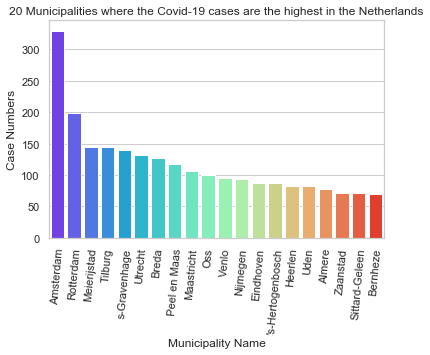

In [77]:
import seaborn as sns
sns.set(style="whitegrid")
ax = sns.barplot(x=df_maxs.Municipality, y=df_maxs.Case_Number, data=df_maxs, palette='rainbow')
ax.set(xlabel='Municipality Name', ylabel='Case Numbers', title='20 Municipalities where the Covid-19 cases are the highest in the Netherlands')
plt.xticks(rotation=85)

In [78]:
df.sort_values(by='Case_Number').head(15) #The municipalities where the case number is the lowest in the NL.

,Municipality,Case_Number,Population,Province
208,Noord-Beveland,0,7395,Zeeland
308,Vlieland,0,1152,Friesland
4,Achtkarspelen,0,27836,Friesland
180,Loppersum,0,9533,Groningen
280,Terschelling,0,4889,Friesland
271,Stadskanaal,0,31688,Groningen
259,Schiermonnikoog,0,947,Friesland
13,Ameland,0,3718,Friesland
217,Oldambt,1,38213,Groningen
224,Ooststellingwerf,1,25472,Friesland


In [79]:
df.sort_values(by='Population', ascending=False).head(30)

,Municipality,Case_Number,Population,Province
16,Amsterdam,330,872779,North Holland
252,Rotterdam,198,651376,South Holland
255,s-Gravenhage,139,545163,South Holland
294,Utrecht,131,357694,Utrecht
92,Eindhoven,87,234456,North Brabant
112,Groningen,13,232922,Groningen
285,Tilburg,144,219800,North Brabant
9,Almere,77,211840,Flevoland
50,Breda,127,184271,North Brabant
205,Nijmegen,94,177698,Gelderland


In [80]:
result = df.groupby(["Province"])['Case_Number'].aggregate(np.sum).reset_index().sort_values('Case_Number', ascending=False)
result


,Province,Case_Number
6,North Brabant,1772
9,South Holland,1095
5,Limburg,1060
7,North Holland,995
3,Gelderland,788
10,Utrecht,506
8,Overijssel,368
1,Flevoland,154
11,Zeeland,104
2,Friesland,95


(array([   0.,  500., 1000., 1500., 2000., 2500.]),
 <a list of 6 Text xticklabel objects>)

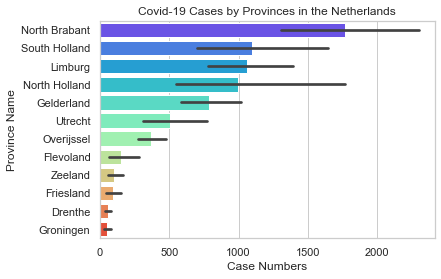

In [81]:
import seaborn as sns
sns.set(style="whitegrid")
ax = sns.barplot(y=df.Province, x=df.Case_Number, data=df, palette='rainbow', estimator=sum, order=result['Province'])
ax.set(ylabel='Province Name', xlabel='Case Numbers', title='Covid-19 Cases by Provinces in the Netherlands')
plt.xticks(rotation=0)

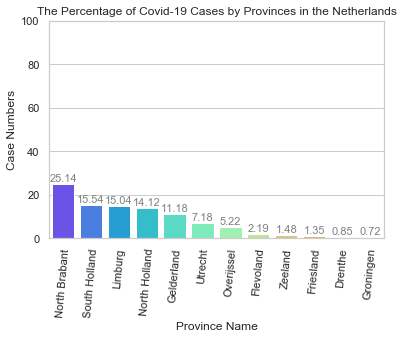

In [82]:
sns.set(style="whitegrid")

total = float(len(result))
g= sns.barplot(x=df.Province, y=df.Case_Number, data=df, palette='rainbow', estimator=lambda y: sum(y) / sum(df.Case_Number) * 100, order=result['Province'], ci=None)
g.set(xlabel='Province Name', ylabel='Case Numbers', title='The Percentage of Covid-19 Cases by Provinces in the Netherlands')
plt.xticks(rotation=85)
ax=g
for p in ax.patches:
             ax.annotate("%.2f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha='center', va='center', fontsize=11, color='gray', xytext=(0, 5),
                 textcoords='offset points')
_ = g.set_ylim(0,100) #To make space for the annotations

In [83]:
#df.to_csv (r'C:\Users\dell\Desktop\NLP\dataset.csv',  index = True, header=True)

## PART VI  - FILTRATION BY MUNICIPALITIES

In [84]:
#Cleaning the municipality names for any confusion or miswriting   
df.Municipality=df.Municipality.str.lower()
df.Municipality=df.Municipality.str.lstrip()
df.Municipality=df.Municipality.str.replace("-"," ")
df.Municipality=df.Municipality.str.replace("'","")
df.Municipality=df.Municipality.str.replace("ú","u")
df.Municipality=df.Municipality.str.replace("â","a")
df.Municipality=df.Municipality.str.replace(","," ")

In [85]:
#df.to_csv (r'C:\Users\dell\Desktop\NLP\dataset.csv',  index = True, header=True)

In [86]:
def matching():
    
    while True:
        
        #Elimination of confusion in the writing
        input_loc = input("Pls, Write your municipality?   ")  
        input_loc = input_loc.lower()
        if '-' in input_loc:
            input_loc = input_loc.replace("-"," ") 
        if "'" in input_loc:
            input_loc = input_loc.replace("'"," ")
        if 'ú'in input_loc:
            input_loc = input_loc.replace("ú","u")
        if "â" in input_loc:
            input_loc = input_loc.replace("â","a")
        if "," in input_loc:
            input_loc = input_loc.replace(","," ")
        input_loc = input_loc.lstrip()
        input_loc = " ".join(input_loc.split())

        
        #Matching including exceptions
        if input_loc == 'den bosch':
            search=df.Case_Number[df.Municipality=="s hertogenbosch"]
            time.sleep(1)
            print(f"The latest total case number in {input_loc.title()} is  {search.to_string(header=False, index=False)}")
                
        elif input_loc == 'den haag':
            search=df.Case_Number[df.Municipality=="s gravenhage"]
            time.sleep(1)
            print(f"The latest total case number in {input_loc.title()} is  {search.to_string(header=False, index=False)}")
        
        elif input_loc == 'bergen':
            bergen_input = input('For Bergen Limburg, please write Limburg, for Bergen Noord Holland, please write Noord Holland:    ')
            bergen_input=bergen_input.lower()
            bergen_input=bergen_input.lstrip()
            bergen_input = " ".join(bergen_input.split())

            if bergen_input=="limburg":
                search=df.Case_Number[df.Municipality=="bergen (l.)"]
                print(f"The latest total case number in {input_loc.title()} is  {search.to_string(header=False, index=False)}")
            
            elif bergen_input=='noord holland':
                search=df.Case_Number[df.Municipality=="bergen (nh.)"]
                print(f"The latest total case number in {input_loc.title()} is  {search.to_string(header=False, index=False)}")
            
            else:
                print('Not matched')
                time.sleep(1)
                matching()
        
        else:
            search=df.Case_Number[df.Municipality==input_loc]
            time.sleep(1)
            print(f"The latest total case number in {input_loc.title()} is  {search.to_string(header=False, index=False)}")
            
        
#matching()